# Homework Assignment 8

In [0]:
!pip install turicreate
!pip install kaggle 
!pip install gensim
!pip install pyLDAvis
!pip install spaCy
!pip install afinn
!pip install nltk
!pip install plotly_express
!pip install geopy
!pip install folium
!pip install mapclassify
!pip install geoplot

import nltk
nltk.download('stopwords')
nltk.download('punkt')
!python -m spacy download en_core_web_lg # Important! you need to restart runtime after install

In [0]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip install --no-binary shapely shapely --force

**Question 1:** Select a book or a movie's subtitle, and find the locations that appear in the book/movie. Then, draw these locations on a map (at least 10 locations) (30pt). Connect the discovered locations with lines according to their order of appearance
in the book. For example, if location B appeared immediately after location A, then draw a line connecting locations A and B (20pt).

In [0]:
!mkdir /root/.kaggle/
import json
import os

# Installing the Kaggle package
# You can also put this file on your Google Drive
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

!mkdir ./datasets
!mkdir ./datasets/dickens
!kaggle datasets download fuzzyfroghunter/dickens -p ./datasets/
!unzip ./datasets/dickens.zip  -d ./datasets/

In [0]:
import spacy
nlp = spacy.load('en_core_web_lg')
datasets_path = "./datasets/dickens"
# oliver_path = f"{datasets_path}/pg730.txt"
traveller_path = f"{datasets_path}/914-0.txt" 	

def get_entites_dict_from_text(text):
    entities_dict= {}
    #using spaCy to get entities
    doc = nlp(text)
    for entity in doc.ents:
        label = entity.label_
        e = entity.text.lower()
        if  label not in entities_dict:
            entities_dict[label] = {}
        if e not in entities_dict[label]:
            entities_dict[label][e] = 0
        entities_dict[label][e] += 1
    return entities_dict

def get_book_entities(path, person_min_times, other_entities_min_times=3):
    txt = open(path,"r", encoding="utf8", errors="ignore").read()
    txt = txt.replace("\n", " ")
    doc = nlp(txt)
    d = get_entites_dict_from_text(txt) 
    entities_dict = {}
    for k in d.keys():
        min_times = other_entities_min_times
        if k == "PERSON":
            min_times = person_min_times
        entity_dict = {k:v for k,v in d[k].items() if v>min_times}
        entities_dict[k] = entity_dict
    return entities_dict

In [0]:
def get_locations_order_from_text(path):
    text = open(path,"r", encoding="utf8", errors="ignore").read()
    text = text.replace("\n", " ")
    last_location = ''
    locations_order = []
    #using spaCy to get entities
    doc = nlp(text)
    for entity in doc.ents:
        label = entity.label_
        e = entity.text.lower()
        if label=='GPE':  
          if last_location =='': 
              last_location = e
          else:
            if last_location != e:
              locations_order.append((last_location, e))
              last_location = e
       
    return set(locations_order)

We will take a look at the locations mentioned in the book The Uncommercial Traveller by Dickens

In [0]:
import itertools

locations_order = get_locations_order_from_text(traveller_path)
# all_locations = set(list(itertools.chain(*locations_order)))
filtered_locations = ['mersey','russia', 'london',  'paris', 'israel', 'britannia', 'england','new york',
                      'liverpool', 'utah', 'new york city','st. louis', 'missouri', 'wales', 'india', 'manchester','london city',
                      'frankfort', 'milan', 'geneva', 'boston', 'philadelphia', 'rome']

Let's get locations longitude and latitude details from geopy 

In [0]:
from functools import lru_cache
from scipy.interpolate import interp1d # for transfaering font size
import time
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Data Science Education App") #  Using OpenStreetMap Nominatim

@lru_cache(maxsize=256)
def get_location(loc):
    time.sleep(1)
    return geolocator.geocode(loc)

In [8]:
import pandas as pd

location_details = pd.DataFrame(columns=['name', 'longitude', 'latitude'])
for loc in filtered_locations:
    location = get_location(loc)
    if location is None:
        continue

    location_details.loc[len(location_details)] = [loc, location.longitude, location.latitude]
location_details

,name,longitude,latitude
0,mersey,-2.642738,53.373922
1,russia,97.745306,64.686314
2,london,-0.127647,51.507322
3,paris,2.351462,48.856697
4,israel,34.866765,31.531311
5,britannia,-0.305055,51.460913
6,england,-0.540240,52.795479
7,new york,-74.006015,40.712728
8,liverpool,-2.991665,53.407154
9,utah,-111.714358,39.422519


Let's get all locations on the map

In [62]:
import folium
from folium.plugins import MarkerCluster
def pop_text(r):
    txt = f"<b>{r['name']}</b><br>"
    return txt

m = folium.Map(zoom_start=8, tiles='CartoDB dark_matter')
mc = MarkerCluster()
for i, r in location_details.iterrows():
    mc.add_child(folium.CircleMarker(location=[r['latitude'],r['longitude']],
                        radius=5,color="#007849", popup=pop_text(r), parse_html=True))
m.add_child(mc)
m

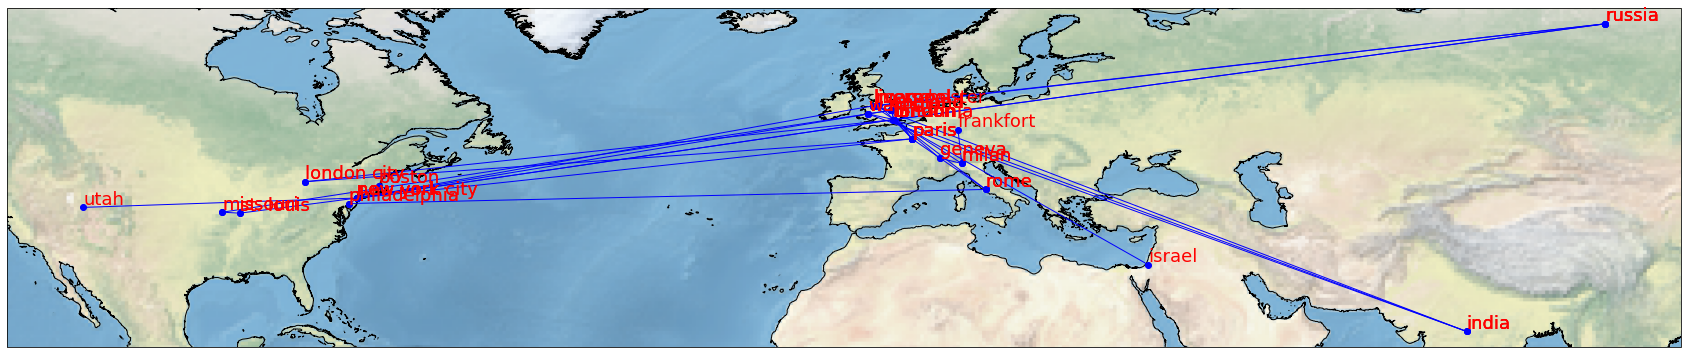

In [14]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

def get_location_from_df(location_name):
  location_row = location_details[location_details['name'] == location_name]
  return [location_row['latitude'].values[0],location_row['longitude'].values[0]]

def draw_map(w_size=30, h_size=30):
    plt.figure(figsize=(w_size, h_size))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.coastlines(resolution='10m', color='black', linewidth=1) # draw with batter coaslines resolution
    return ax

ax = draw_map()
locations_order = set(locations_order)
for src_location, dst_location in locations_order:
  if src_location in filtered_locations and dst_location in filtered_locations: 
    src_lat, src_long = get_location_from_df(src_location)
    dst_lat, dst_long = get_location_from_df(dst_location)
   
    plt.plot([src_long, dst_long], [src_lat, dst_lat],
            color='blue', linewidth=1, marker='o',
            )
    ax.text(src_long, src_lat+0.5, src_location, fontsize=18, color="red", transform=ccrs.PlateCarree())
    ax.text(dst_long, dst_lat+0.5, dst_location, fontsize=18, color="red", transform=ccrs.PlateCarree())

ax.stock_img() # add colors


**Question 2:** Select a country's' statistic from the [World Development Indicators dataset](https://www.kaggle.com/worldbank/world-development-indicators) (Please notice there are several files in the dataset, such as _Indicators.csv_).
Then, create a choropleth map displaying how the selected statistics changed over time (15pt) 
    
**Bonus:** Create a short animation that displays how the chosen statistics changed over time (15pt)

In [0]:
!mkdir ./datasets/worldbank
!kaggle datasets download worldbank/world-development-indicators -p ./datasets/
!unzip ./datasets/world-development-indicators.zip  -d ./datasets/worldbank

In [0]:
import pandas as pd

indicators_df = pd.read_csv('datasets/Indicators.csv')

In [44]:
indicators_df.head(5)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06


We will examine Profit tax (% of commercial profits) indicator over the years 2013 - 2015

In [60]:
tax_profit = indicators_df[indicators_df['IndicatorName']=='Profit tax (% of commercial profits)']
tax_profit.head(10)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
5377840,Arab World,ARB,Profit tax (% of commercial profits),IC.TAX.PRFT.CP.ZS,2013,11.250000
5378270,Caribbean small states,CSS,Profit tax (% of commercial profits),IC.TAX.PRFT.CP.ZS,2013,26.800000
5378762,Central Europe and the Baltics,CEB,Profit tax (% of commercial profits),IC.TAX.PRFT.CP.ZS,2013,9.400000
5379318,East Asia & Pacific (all income levels),EAS,Profit tax (% of commercial profits),IC.TAX.PRFT.CP.ZS,2013,17.656000
5380048,East Asia & Pacific (developing only),EAP,Profit tax (% of commercial profits),IC.TAX.PRFT.CP.ZS,2013,18.155556
5380569,Euro area,EMU,Profit tax (% of commercial profits),IC.TAX.PRFT.CP.ZS,2013,11.978947
5381168,Europe & Central Asia (all income levels),ECS,Profit tax (% of commercial profits),IC.TAX.PRFT.CP.ZS,2013,11.223404
5381961,Europe & Central Asia (developing only),ECA,Profit tax (% of commercial profits),IC.TAX.PRFT.CP.ZS,2013,9.478947
5382512,European Union,EUU,Profit tax (% of commercial profits),IC.TAX.PRFT.CP.ZS,2013,12.475000
5382996,Fragile and conflict affected situations,FCS,Profit tax (% of commercial profits),IC.TAX.PRFT.CP.ZS,2013,15.873333


We will extract countries locations from geopandas

In [55]:
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline

print(geopandas.datasets.get_path('naturalearth_lowres'))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head(10)

/usr/local/lib/python3.6/dist-packages/geopandas/datasets/naturalearth_lowres/naturalearth_lowres.shp


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
5,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997 49.21498, 86.59878 48.54918..."
6,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819 41.30864, 55.92892 44.99586..."
7,6909701,Oceania,Papua New Guinea,PNG,28020.0,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ..."
8,260580739,Asia,Indonesia,IDN,3028000.0,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ..."
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."


In [0]:
import mapclassify
import geopandas
import geoplot

def create_tax_result_by_year(df, year):
    df = df[df['Year']==year]
    tax_profit_with_polygon = pd.merge(df[['CountryCode', 'Value']], world, left_on='CountryCode', right_on='iso_a3',how='right')
    tax_profit_with_polygon = tax_profit_with_polygon.fillna(0)

    tax_stats = tax_profit_with_polygon['Value']
    scheme = mapclassify.Quantiles(tax_stats)

    ax = geoplot.choropleth(
        world, hue=tax_stats, scheme=scheme,
        cmap='Greens', figsize=(20, 20)
        )
    ax.set_title(f'{year} Profit tax (% of commercial profits) for countries', fontsize=42)  
    return ax

In [95]:
from tqdm import tqdm
import imageio # need install imageio 
!mkdir ./images
!mkdir ./images/tax
#Creating image for the election in each year
years = list(tax_profit['Year'].unique())
images_path = "./images/tax/"
images_list = []
for y in tqdm(years):
    ax = create_tax_result_by_year(tax_profit, y)
    img_path = f"{images_path}/{y}_tax.png"
    plt.savefig(img_path)
    images_list.append(img_path)
    plt.clf()

import imageio
images = []
for filename in images_list:
    images.append(imageio.imread(filename))
imageio.mimsave(f"{images_path}/all_tax.gif", images, duration=1 )

mkdir: cannot create directory ‘./images’: File exists
mkdir: cannot create directory ‘./images/tax’: File exists


100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

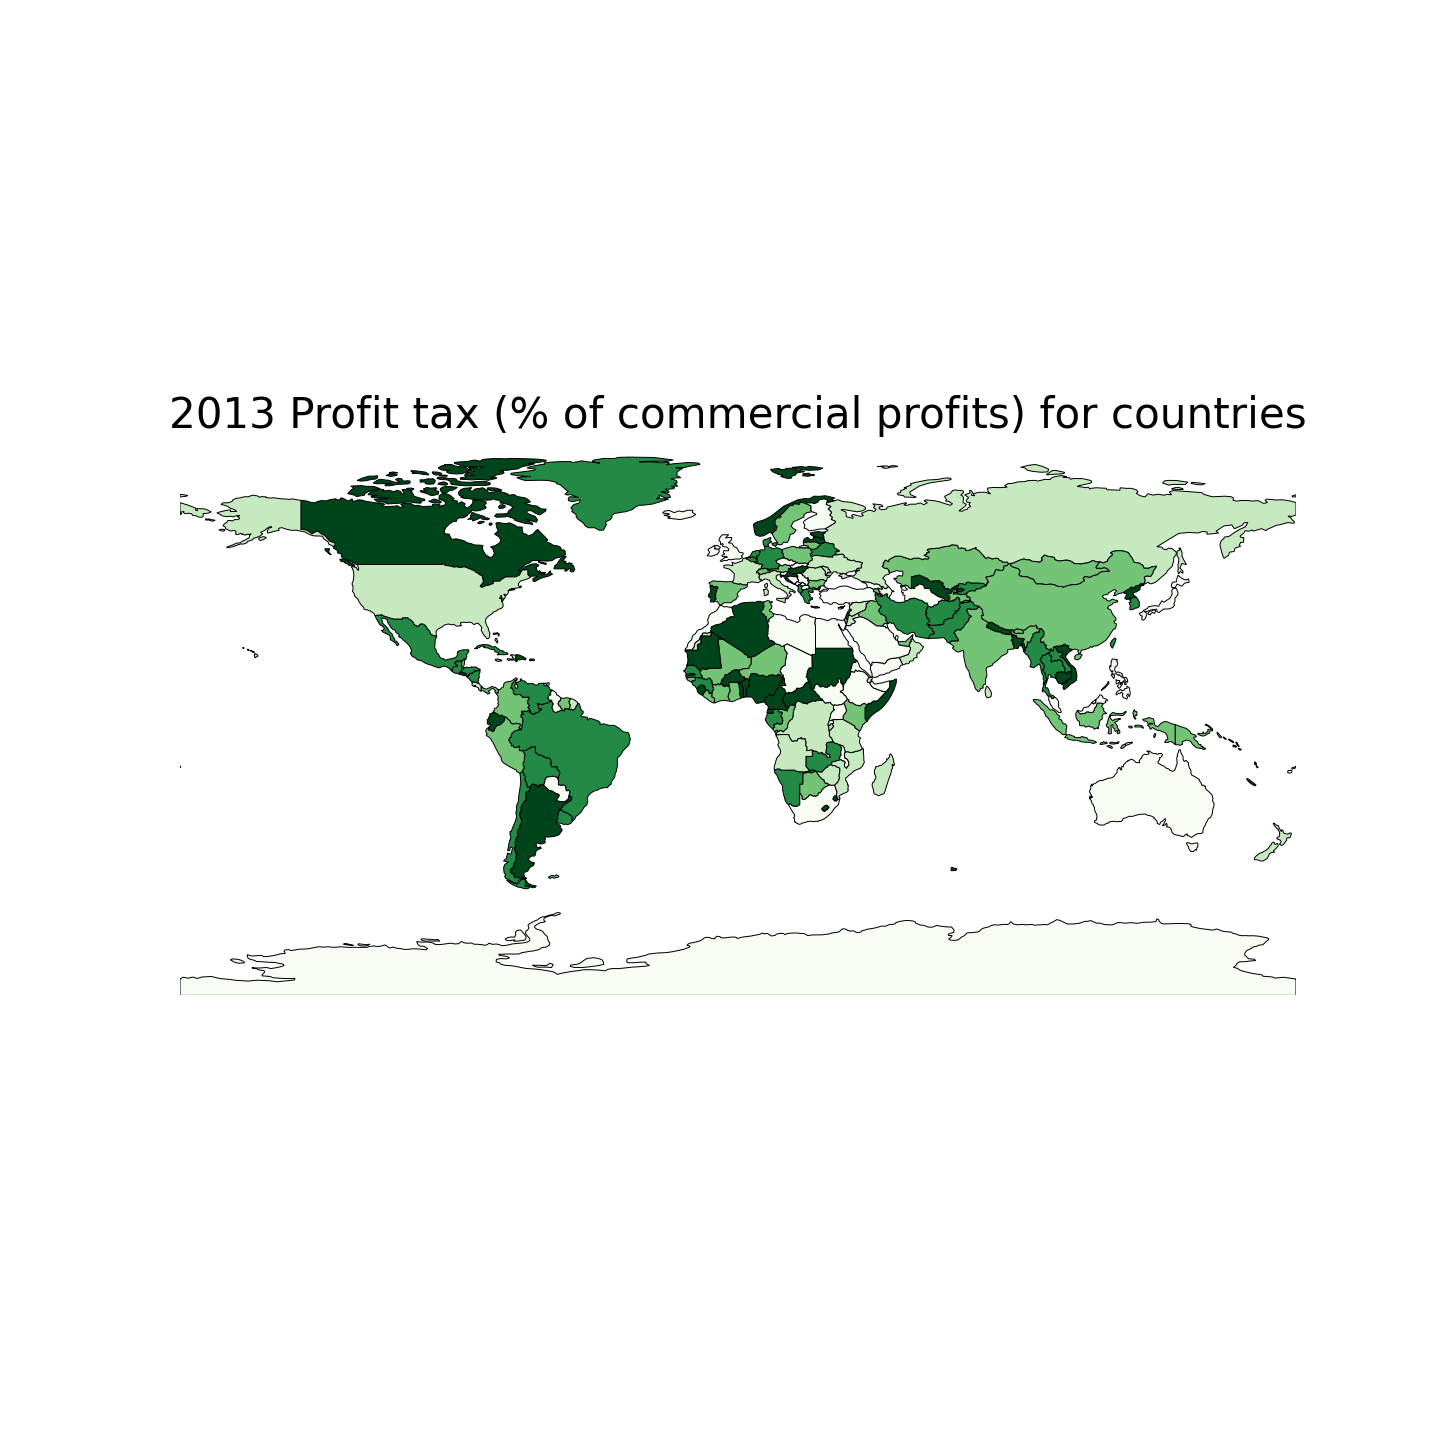

In [96]:
from IPython.display import Image
Image('./images/tax/all_tax.gif', format='png')

**Question 3:** Select a request type from [San Francisco 311 dataset](https://www.kaggle.com/datasf/case-data-from-san-francisco-311).
Create an interactive map that somehow presents in which areas this request occurs the most (35pt).

In [0]:
!mkdir ./datasets/san-francisco
!kaggle datasets download datasf/case-data-from-san-francisco-311 -p ./datasets/
!unzip ./datasets/case-data-from-san-francisco-311.zip  -d ./datasets/san-francisco

In [97]:
sf_data = pd.read_csv("./datasets/san-francisco/Case_Data_from_San_Francisco_311__SF311.csv")
sf_data.head(10)

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Supervisor District,Neighborhood,Point,Source,Media URL
0,322571,11/30/2008 11:53:00 PM,12/01/2008 03:19:00 PM,12/01/2008 03:19:00 PM,Closed,NaN,PUC - Electric/Power - G,General Requests,puc - electric - request_for_service,puc - electric - request_for_service,Intersection of 21ST ST and CAPP ST,9.0,Mission,"(37.7571008516766, -122.417811874214)",Voice In,NaN
1,322568,11/30/2008 11:13:00 PM,07/21/2009 04:24:00 PM,07/21/2009 04:24:00 PM,Closed,NaN,DPW Ops Queue,Illegal Postings,Illegal Postings - Posting_Too_Large_in_Size,Posting_Too_Large_in_Size on Sidewalk,Intersection of BUSH ST and VAN NESS AVE,3.0,Nob Hill,"(37.7884895281133, -122.421948485141)",Voice In,NaN
2,322567,11/30/2008 11:07:00 PM,12/27/2008 06:07:00 AM,12/27/2008 06:07:00 AM,Closed,NaN,DPW Ops Queue,Illegal Postings,Illegal Postings - Affixed_Improperly,Affixed_Improperly on Sidewalk,Intersection of EUCLID AVE and MASONIC AVE,2.0,Western Addition,"(37.7850837365507, -122.447620029034)",Voice In,NaN
3,322566,11/30/2008 10:56:00 PM,07/21/2009 04:24:00 PM,07/21/2009 04:24:00 PM,Closed,NaN,DPW Ops Queue,Street and Sidewalk Cleaning,Sidewalk_Cleaning,Garbage,"1566 HYDE ST, SAN FRANCISCO, CA, 94109",3.0,Nob Hill,"(37.795328529, -122.418067787)",Voice In,NaN
4,322565,11/30/2008 10:46:00 PM,12/13/2008 10:50:00 AM,12/13/2008 10:50:00 AM,Closed,NaN,RPD Park Service Area GGP Queue,Rec and Park Requests,Park - Structural_Maintenance,Other,"GGP Panhandle, SAN FRANCISCO, CA, 94117",5.0,Haight Ashbury,"(37.772204762, -122.4487004)",Voice In,NaN
5,322564,11/30/2008 10:43:00 PM,12/01/2008 04:07:00 PM,12/01/2008 04:07:00 PM,Closed,NaN,DPW Ops Queue,Graffiti Public Property,Offensive Graffiti on Public Property,Other_enter_additional_details_below - Offensive,"1 NOB HILL CIR, SAN FRANCISCO, CA, 94108",3.0,Nob Hill,"(37.79140462, -122.410247421)",Voice In,NaN
6,322560,11/30/2008 10:24:00 PM,07/21/2009 04:24:00 PM,07/21/2009 04:24:00 PM,Closed,NaN,DPW Ops Queue,Street and Sidewalk Cleaning,Illegal_Dumping,Garbage,Intersection of TAYLOR ST and TURK ST,6.0,Downtown/Civic Center,"(37.7832142923006, -122.410764953722)",Voice In,NaN
7,322559,11/30/2008 10:20:00 PM,12/01/2008 06:07:00 AM,12/01/2008 06:07:00 AM,Closed,NaN,DPW Ops Queue,Street and Sidewalk Cleaning,Illegal_Dumping,Mattress,"1601 SACRAMENTO ST, SAN FRANCISCO, CA, 94109",3.0,Nob Hill,"(37.791643509125, -122.419260423291)",Voice In,NaN
8,322558,11/30/2008 10:04:00 PM,11/30/2008 10:18:00 PM,11/30/2008 10:18:00 PM,Closed,NaN,311 Service Request Queue,311 External Request,Damaged_Property,NaN,Intersection of CARL ST and COLE ST,5.0,Haight Ashbury,"(37.765800070469, -122.449958075232)",Voice In,NaN
9,322556,11/30/2008 09:34:00 PM,12/09/2008 08:07:00 AM,12/09/2008 08:07:00 AM,Closed,NaN,DPW Ops Queue,Street and Sidewalk Cleaning,Sidewalk_Cleaning,Human_waste_or_urine,Intersection of 25TH ST and LUCKY ST,9.0,Mission,"(37.7509362479361, -122.413364630104)",Voice In,NaN


Let's check which categorys are with the highest requests count

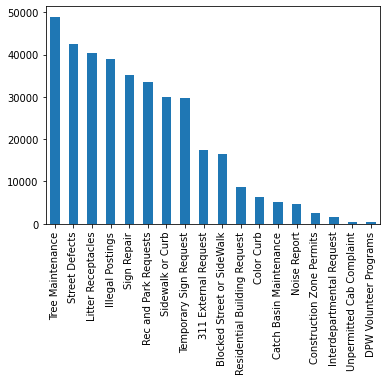

In [101]:
sf_data.Category.value_counts(ascending=False)[10:].plot(kind='bar')

In [125]:
sf_data.Category.value_counts(ascending=False)[10:]

Tree Maintenance                48932
Street Defects                  42477
Litter Receptacles              40354
Illegal Postings                38951
Sign Repair                     35211
Rec and Park Requests           33530
Sidewalk or Curb                29900
Temporary Sign Request          29669
311 External Request            17507
Blocked Street or SideWalk      16483
Residential Building Request     8613
Color Curb                       6216
Catch Basin Maintenance          5206
Noise Report                     4765
Construction Zone Permits        2552
Interdepartmental Request        1554
Unpermitted Cab Complaint         392
DPW Volunteer Programs            371
Name: Category, dtype: int64

In [0]:
path_to_shapefile = "datasets/san-francisco/Shapefiles (2)/Analysis Neighborhoods/geo_export_7c3449d4-91cf-4b41-8929-3a62ae10c1ca.shp"
shp  = geopandas.read_file(path_to_shapefile)

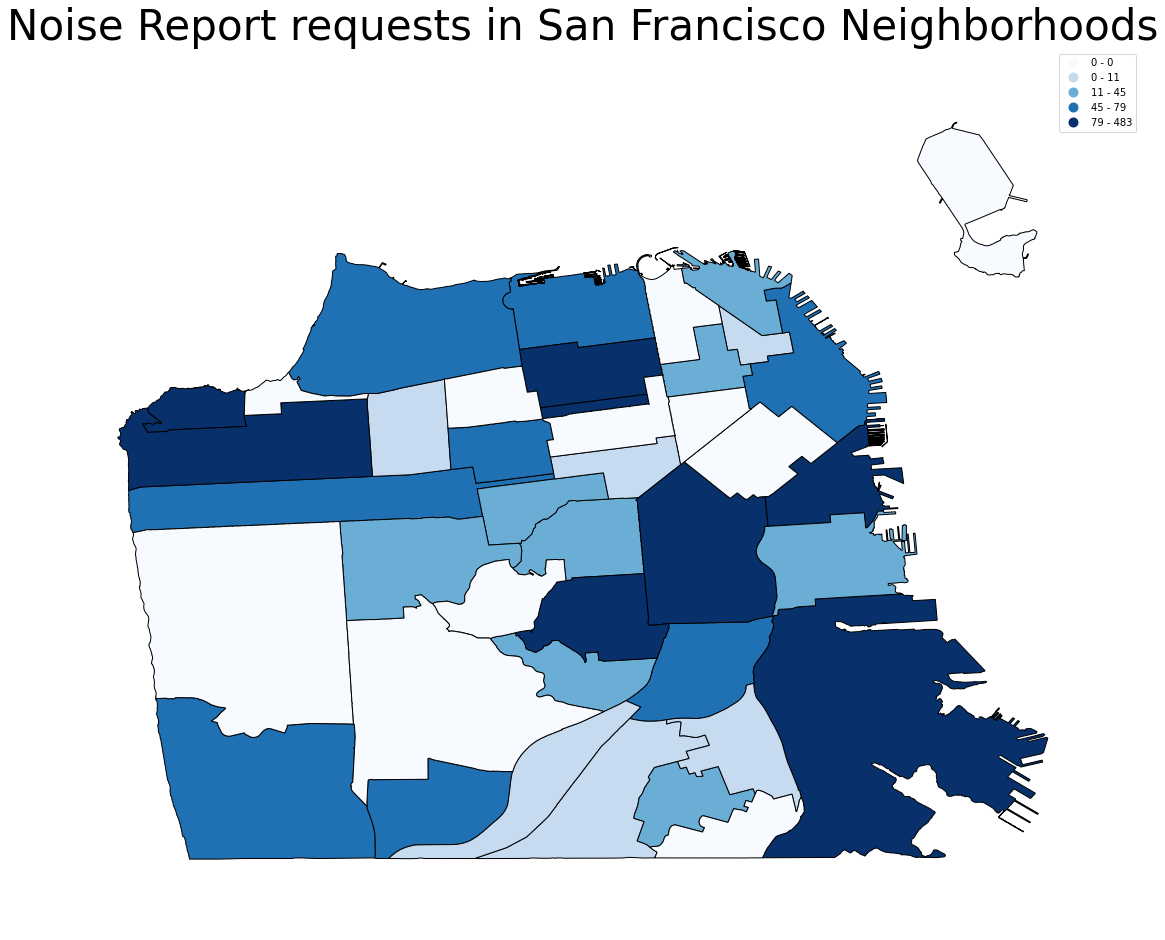

In [132]:
import mapclassify
import geopandas
import geoplot

def get_map_for_category_requests(request, cmap):
  # filter first by request type
  filter_category = sf_data[sf_data['Category']==request]
  requests_por_nh = filter_category[['Category', 'Neighborhood']].groupby('Neighborhood').count().reset_index()
  requests_por_nh = requests_por_nh.rename(columns={'Category':'count'})

  requests_with_polygon = pd.merge(requests_por_nh, shp, left_on='Neighborhood', right_on='nhood',how='right')
  requests_with_polygon = requests_with_polygon.fillna(0)

  requests_stats = requests_with_polygon['count']
  scheme = mapclassify.Quantiles(requests_stats)

  ax = geoplot.choropleth(
      shp, hue=requests_stats, scheme=scheme,
      cmap=cmap, figsize=(20, 20), legend=True
      )
  ax.set_title(f'{request} requests in San Francisco Neighborhoods', fontsize=42)  

ax = get_map_for_category_requests('Noise Report', 'Blues')
ax

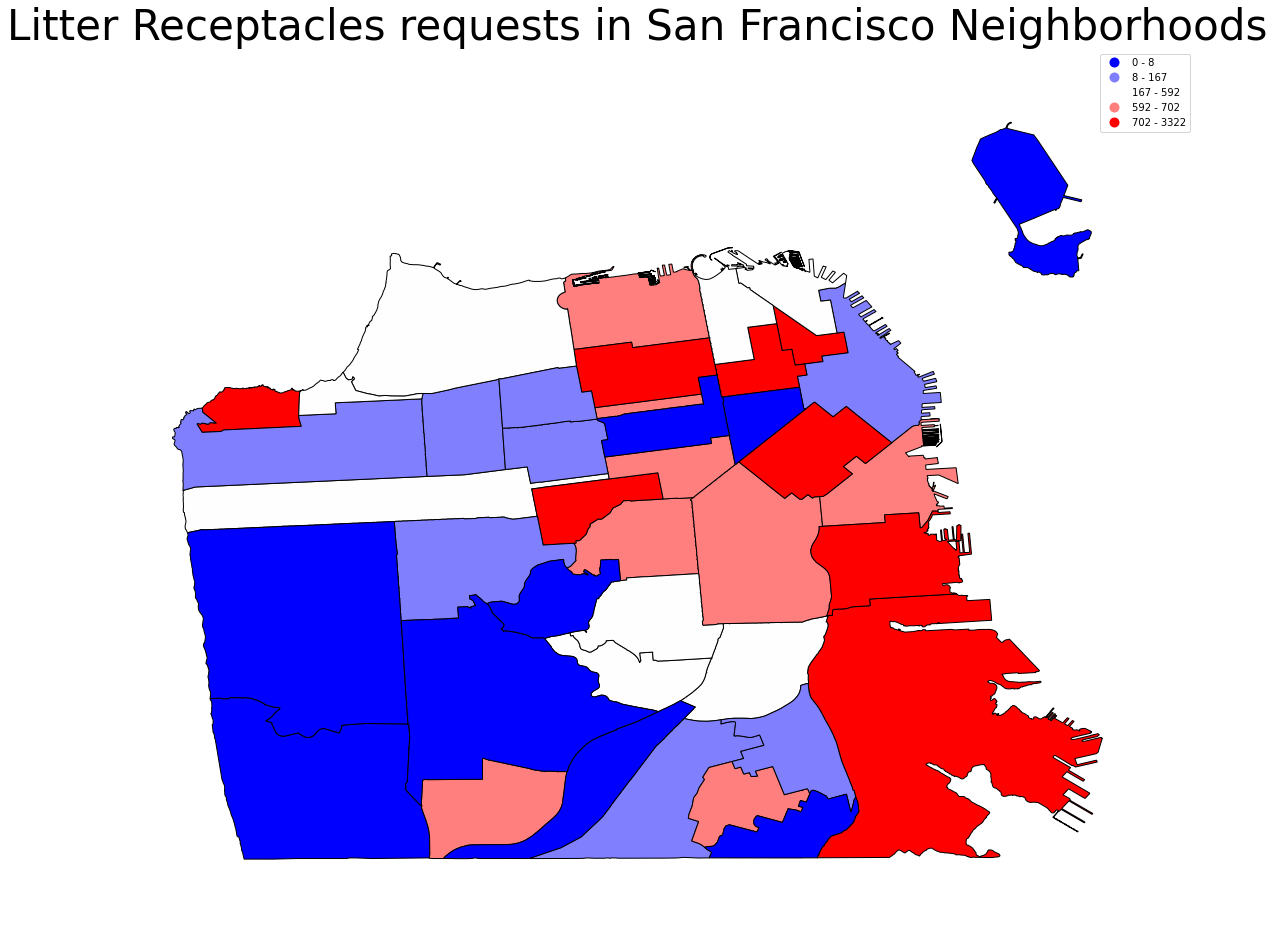

In [135]:
ax = get_map_for_category_requests('Litter Receptacles', 'bwr')
ax

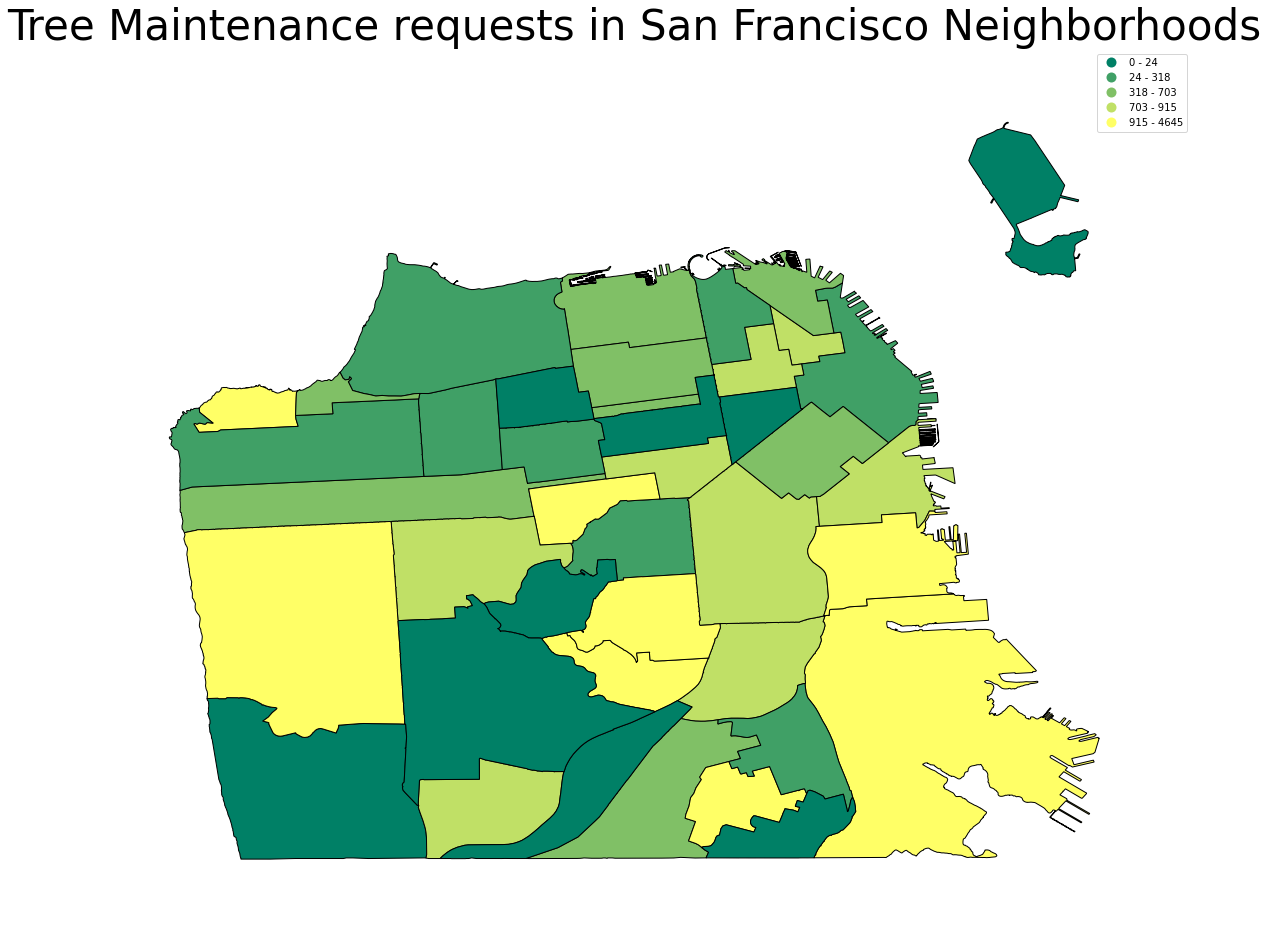

In [136]:
ax = get_map_for_category_requests('Tree Maintenance', 'summer')
ax